In [80]:
import os
import re

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI
from bot.utils.files import load_tokens_from_file
from bot.utils.coinmarketcap import get_top_tokens
from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

import pandas as pd
# pd.options.display.float_format = '{:.2f}'.format

import polars as pl
import polars_ols as pls

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [81]:
def sort_pairs(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("pair_min"),
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("pair_max"),
    ]).drop('coin1', 'coin2').rename({'pair_min': 'coin1', 'pair_max': 'coin2'}).select('coin1', 'coin2', pl.exclude('coin1', 'coin2'))

In [82]:
# get_top_tokens(limit=1000, output_file='./bot/config/top_1000_tokens.txt')

#### Скачиваем данные с Bybit

In [83]:
async def get_data(symbol, interval, n_iters):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df['bybit_linear'].sort_index()
    df['Returns'] = df['Close'].pct_change()
    df['Log_price'] = np.log(df['Close'] + 1)
    df['Log_returns'] = np.log(df['Returns'] + 1)
    return df.dropna()

In [84]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

In [85]:
res = await get_data(symbol='ADA_USDT', interval='1h', n_iters=1)
res.shape

(999, 11)

In [86]:
top_1000_tokens = load_tokens_from_file("./data/top_1000_tokens.txt")
tokens_to_del = ['USDT', 'USDC', 'LEO', 'USDe']
token_list = [x + '_USDT' for x in top_1000_tokens if x not in tokens_to_del]

In [87]:
prices = await exc_manager.get_prices()
prices = prices['bybit_linear']
len(prices)

557

In [88]:
with open('./bot/config/tokens.txt', 'r') as file:
    current_tokens = [line.strip() for line in file.readlines()]
len(current_tokens)

66

In [89]:
all_ = db_manager.get_orderbooks()
all_tokens = all_['token'].unique().to_list()

In [90]:
token_list = []

for token in sorted(all_tokens):
    first_date = db_manager.get_oldest_date_in_orderbook(token)
    
    if first_date < datetime(2025, 10, 25, 12, tzinfo=ZoneInfo("Europe/Moscow")):
        token_list.append(token)
len(token_list)

40

In [91]:
# Настройки параметров
interval = '1d'
n_iters = 1
start_date = datetime(2025, 5, 1, tzinfo=ZoneInfo("Europe/Moscow"))
end_date = datetime(2025, 11, 12, tzinfo=ZoneInfo("Europe/Moscow"))
min_volume = 1_000_000
days_ago = 30 # За сколько последних дней смотреть волатильность
max_volatility = 55
max_price = 20

In [92]:
main_df = pd.DataFrame()

token_dict = {'PEPE_USDT': '1000PEPE_USDT', 'SHIB_USDT': 'SHIB1000_USDT', 'FLOKI_USDT': '1000FLOKI_USDT',
             'BONK_USDT': '1000BONK_USDT', 'BTT_USDT': '1000BTT_USDT', 'XEC_USDT': '1000XEC_USDT',
             'LUNC_USDT': '1000LUNC_USDT', 'SATS_USDT': '10000SATS_USDT', 'TURBO_USDT': '1000TURBO_USDT',
             'CAT_USDT': '1000CAT_USDT'}
bad_tokens = []
good_tokens = []

for token in tqdm(token_list):
    df = await get_data(symbol=token, interval=interval, n_iters=n_iters)
    df = df.reset_index()

    if df.empty:
        continue
    
    # first_date = df['Date'].head(1).item().floor('D')
    # last_date = df['Date'].tail(1).item().floor('D')
    
    # if first_date > pd.Timestamp('2025-06-10', tz='Europe/Moscow'):
    #     continue
    # if last_date < pd.Timestamp('2025-11-10', tz='Europe/Moscow'):
    #     continue

    row = df[df['Date'].dt.date == (end_date - timedelta(days=2)).date()]
    vol24 = row['Turnover'].item() # Берём предпоследнюю запись, потому что последний день будет половинчатым
    if vol24 < min_volume:
        if token in current_tokens:
            print(f'{token} недостаточно торгового объёма ({int(vol24):_})')
            bad_tokens.append(token)
        continue
    
    df = df[(df['Date'] > start_date) & (df['Date'] < end_date)]
    df = df.set_index('Date')
    daily_df = df[-days_ago:]
    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100

    if daily_df['Max_range_perc'].max() > max_volatility:
        if token in current_tokens:
            print(f'{token} высокая волатильность: {daily_df['Max_range_perc'].max():.1f}%')
            bad_tokens.append(token)
        continue

    if daily_df['Close'][-1] > max_price:
        continue

    main_df[f'{token[:-5]}_price'] = df['Close']
    main_df[f'{token[:-5]}_log_returns'] = df['Log_returns']
    main_df[f'{token[:-5]}_log_price'] = df['Log_price']
    good_tokens.append(token)

  0%|          | 0/40 [00:00<?, ?it/s]

.......

In [14]:
main_df.shape

(195, 120)

In [15]:
len(current_tokens), len(bad_tokens), len(good_tokens)

(66, 0, 40)

In [14]:
[current_tokens.remove(token) for token in bad_tokens]
len(current_tokens)

66

In [16]:
len(good_tokens), len(set(good_tokens))

(40, 40)

#### Distance approach

In [17]:
from bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
import itertools
import math

In [18]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [20]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления
max_days = 180 # За сколько дней считать расстояние
tokens = [x[:-5] for x in set(token_list)]
dfs = []
# token_dp = {}
token_std = {}
token_dist = {}

for token in tokens:
    try:
        df_token = main_df[[f'{token}_price']].rename(columns={f'{token}_price': 'price'})
        df_token['token'] = token
        df_token = pl.from_pandas(df_token, include_index=True).rename({'Date': 'time'}).tail(max_days)
    except KeyError:
        print(token)
        continue
    
    try:
        dp = coin_information['bybit_linear'][token + '_USDT']['qty_step']
    except IndexError:
        dp = 0

    # token_dp[token] = dp
    token_std[token] = df_token['price'].std()
    token_dist[token] = df_token['price'].max() - df_token['price'].min()
    dfs.append(df_token)

In [21]:
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
curr_prices = price_df.drop('time').tail(1).transpose(include_header=True, header_name='coin', column_names=['price'])
price_df.tail(1)

time,MORPHO,IMX,DYDX,GMT,ORDI,STRK,JASMY,SUSHI,POL,KSM,GRT,ARKM,FLOW,OP,CRV,BLUR,GALA,KAS,IOTA,ROSE,MANTA,ARB,SEI,MOVE,SAND,STX,1INCH,MANA,SUI,TIA,XRP,APT,LDO,NEAR,CHZ,ONDO,DOT,VET,CELO,RENDER
"datetime[ns, Europe/Moscow]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-11-11 03:00:00 MSK,1.9876,0.4243,0.3096,0.0231,4.932,0.1448,0.009268,0.4917,0.171,11.376,0.06344,0.3243,0.2749,0.4062,0.4681,0.04528,0.009881,0.04928,0.1414,0.02117,0.10756,0.2753,0.1743,0.05849,0.1968,0.4116,0.2036,0.2235,2.0065,0.9515,2.39,3.088,0.8025,2.546,0.03262,0.6489,3.0522,0.01688,0.2323,2.32


In [22]:
price_df.shape, price_df.drop_nans().shape

((180, 41), (180, 41))

In [23]:
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

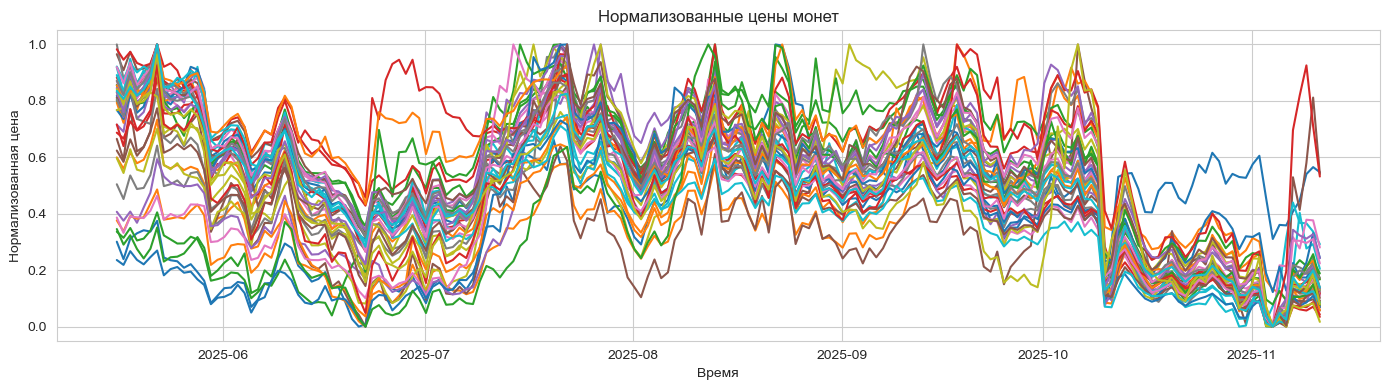

In [24]:
# Нарисуем график с нормализованными ценами
price_cols = [c for c in normed_df.columns if c != 'time']

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df['time'].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
plt.grid(True)
plt.tight_layout()

In [25]:
# Посчитаем евклидово расстояние между парами криптовалют
results = []

# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    std = np.std((normed_df[col1] - normed_df[col2]).to_numpy())
    results.append((col1, col2, distance, std))

In [26]:
std_df = pl.DataFrame({"token": list(token_std.keys()), "std_value": list(token_std.values())})
max_dist_df = pl.DataFrame({"token": list(token_dist.keys()), "max_dist": list(token_dist.values())})

# max_dist_df

In [27]:
dist_df = pl.DataFrame(results, schema=["coin1", "coin2", "dist", "std"], orient="row").sort('dist')
dist_df = dist_df.join(curr_prices, left_on='coin1', right_on='coin').rename({'price': 'price1'})
dist_df = dist_df.join(curr_prices, left_on='coin2', right_on='coin').rename({'price': 'price2'})
dist_df = dist_df.filter(
    (pl.col('price1') / pl.col('price2') < 4) & (pl.col('price1') / pl.col('price2') > 0.25)
)

In [28]:
dist_df = dist_df.join(std_df, left_on="coin1", right_on="token").rename({"std_value": "std_1"})
dist_df = dist_df.join(std_df, left_on="coin2", right_on="token").rename({"std_value": "std_2"})

dist_df = dist_df.join(max_dist_df, left_on="coin1", right_on="token").rename({"max_dist": "dist_1"})
dist_df = dist_df.join(max_dist_df, left_on="coin2", right_on="token").rename({"max_dist": "dist_2"})

In [29]:
dist_df

coin1,coin2,dist,std,price1,price2,std_1,std_2,dist_1,dist_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""GALA""","""VET""",0.542705,0.033376,0.009881,0.01688,0.002811,0.003444,0.01256,0.01667
"""GRT""","""KAS""",0.714087,0.053199,0.06344,0.04928,0.014632,0.016276,0.06767,0.07384
"""GRT""","""BLUR""",0.766597,0.052858,0.06344,0.04528,0.014632,0.016649,0.06767,0.07046
"""GRT""","""VET""",0.777055,0.0474,0.06344,0.01688,0.014632,0.003444,0.06767,0.01667
"""MANTA""","""STX""",0.789799,0.058476,0.10756,0.4116,0.0503,0.137207,0.2343,0.6469
…,…,…,…,…,…,…,…,…,…
"""STRK""","""SEI""",4.334485,0.291982,0.1448,0.1743,0.01568,0.057542,0.0786,0.2126
"""DYDX""","""STRK""",4.395214,0.223995,0.3096,0.1448,0.119122,0.01568,0.4693,0.0786
"""XRP""","""APT""",4.449203,0.282598,2.39,3.088,0.389239,0.660997,1.5372,3.156


In [ ]:
# Добавить фичи: скорость возврата к среднему

#### Cointegration approach

In [30]:
ret_cols = [col for col in main_df.columns if '_log_price' in col]
corr_matrix = main_df[ret_cols].corr()

In [31]:
corr_matrix

,1INCH_log_price,APT_log_price,ARB_log_price,ARKM_log_price,BLUR_log_price,CELO_log_price,CHZ_log_price,CRV_log_price,DOT_log_price,DYDX_log_price,...,ROSE_log_price,SAND_log_price,SEI_log_price,STRK_log_price,STX_log_price,SUI_log_price,SUSHI_log_price,TIA_log_price,VET_log_price,XRP_log_price
1INCH_log_price,1.000000,0.514712,0.782095,0.600338,0.526538,0.571810,0.736291,0.830209,0.639803,0.730309,...,0.561749,0.730502,0.810738,0.475304,0.529876,0.782046,0.840438,0.412771,0.619676,0.826618
APT_log_price,0.514712,1.000000,0.461491,0.866637,0.886605,0.826563,0.848263,0.568707,0.882587,0.869672,...,0.864589,0.878046,0.456041,0.641199,0.909893,0.831573,0.692060,0.882089,0.896573,0.157658
ARB_log_price,0.782095,0.461491,1.000000,0.640466,0.453084,0.511501,0.716315,0.790612,0.645996,0.774108,...,0.515101,0.703528,0.802849,0.414238,0.432377,0.759696,0.849118,0.376463,0.618275,0.786964
ARKM_log_price,0.600338,0.866637,0.640466,1.000000,0.908313,0.827060,0.937624,0.648924,0.969541,0.902986,...,0.938341,0.947931,0.485173,0.717145,0.875950,0.886264,0.777362,0.886865,0.944177,0.301388
BLUR_log_price,0.526538,0.886605,0.453084,0.908313,1.000000,0.860345,0.877905,0.654574,0.910478,0.846835,...,0.928255,0.928752,0.366531,0.651645,0.964914,0.864223,0.748892,0.968224,0.963029,0.177693
CELO_log_price,0.571810,0.826563,0.511501,0.827060,0.860345,1.000000,0.875219,0.671345,0.857580,0.759859,...,0.853160,0.853483,0.369854,0.808537,0.841120,0.830075,0.734228,0.841499,0.883188,0.289158
CHZ_log_price,0.736291,0.848263,0.716315,0.937624,0.877905,0.875219,1.000000,0.765947,0.962651,0.911212,...,0.904717,0.952187,0.582747,0.791486,0.838411,0.926362,0.853265,0.819026,0.933973,0.479519
CRV_log_price,0.830209,0.568707,0.790612,0.648924,0.654574,0.671345,0.765947,1.000000,0.680012,0.783226,...,0.584960,0.771349,0.723611,0.417530,0.635646,0.867519,0.930547,0.539131,0.720570,0.770398
DOT_log_price,0.639803,0.882587,0.645996,0.969541,0.910478,0.857580,0.962651,0.680012,1.000000,0.909532,...,0.940258,0.957680,0.456458,0.774304,0.866962,0.899710,0.790429,0.888523,0.955647,0.324634
DYDX_log_price,0.730309,0.869672,0.774108,0.902986,0.846835,0.759859,0.911212,0.783226,0.909532,1.000000,...,0.853450,0.940191,0.688003,0.558844,0.845423,0.937301,0.881943,0.803467,0.918380,0.477160


In [32]:
# token = 'SUSHI'
# token_df = corr_matrix[f'{token}_log_price']
# token_df.shape

In [33]:
# token_df[abs(token_df) < 0.1]

In [34]:
# token_df[abs(token_df) > 0.75]

In [35]:
stacked = corr_matrix.stack().reset_index()
stacked.columns = ['stock1', 'stock2', 'correlation']
# filtered_pairs = stacked[(stacked['correlation'] > 0.6) & (stacked['stock1'] < stacked['stock2'])].reset_index(drop=True)

In [36]:
results = []
processed = []
n_rows = 180 # Сколько последних записей учитывать

for _, row in tqdm(stacked.iterrows(), total=stacked.shape[0]):
    stock1 = row['stock1'].replace('_log_price', '_price')
    stock2 = row['stock2'].replace('_log_price', '_price')

    if stock1 == stock2:
        continue

    # if (stock1, stock2) in processed or (stock2, stock1) in processed:
    #     continue
        
    corr_value = row['correlation']

    data = main_df[[stock1, stock2]].replace([np.inf, -np.inf], np.nan).dropna()
    data = data[-n_rows:]

    if data.empty:
        print(f"Пара {stock1}-{stock2} пропущена, т.к. нет данных после очистки")
        continue

    last_price_1 = data[stock1].iloc[-1]
    last_price_2 = data[stock2].iloc[-1]
    diff = last_price_2 / last_price_1
    if diff > 4 or diff < 0.25:
        continue

    adf_stat_1, p_value_1, _ = coint(data[stock1], data[stock2], trend='c')
    adf_stat_2, p_value_2, _ = coint(data[stock2], data[stock1], trend='c')

    beta_1 = np.cov(data[stock1].values, data[stock2].values)[0, 1] / np.var(data[stock1].values)
    beta_2 = np.cov(data[stock2].values, data[stock1].values)[0, 1] / np.var(data[stock2].values)

    results.append({
        'stock1': stock1,
        'stock2': stock2,
        'correlation': corr_value,
        'adf_stat_1': adf_stat_1,
        'p_value_1': p_value_1,
        'adf_stat_2': adf_stat_2,
        'p_value_2': p_value_2,
        'beta_1': beta_1,
        'beta_2': beta_2
    })

    processed.append((stock1, stock2))

result_df = pd.DataFrame(results)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [37]:
coint_df = pl.DataFrame(result_df).rename({'stock1': 'coin1', 'stock2': 'coin2'}).with_columns(
    pl.col("coin1").str.replace("_price", ""),
    pl.col("coin2").str.replace("_price", "")
)

In [38]:
coint_df

coin1,coin2,correlation,adf_stat_1,p_value_1,adf_stat_2,p_value_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64
"""1INCH""","""ARB""",0.782095,-3.047741,0.099289,-1.903096,0.578436,1.435542,0.409266
"""1INCH""","""ARKM""",0.600338,-2.844414,0.151962,-2.069196,0.492474,1.442623,0.284804
"""1INCH""","""CELO""",0.57181,-3.055772,0.097536,-3.645365,0.021506,0.686923,0.616067
"""1INCH""","""CRV""",0.830209,-3.12388,0.083607,-2.924585,0.129237,3.155125,0.221008
"""1INCH""","""DYDX""",0.730309,-2.966181,0.118465,-1.510632,0.757093,2.138085,0.280324
…,…,…,…,…,…,…,…,…
"""XRP""","""ONDO""",0.697357,-1.7403,0.658241,-1.395919,0.798909,0.245388,2.544691
"""XRP""","""ORDI""",0.474376,-1.593629,0.723572,-1.531908,0.748755,2.608918,0.11602
"""XRP""","""RENDER""",0.248123,-1.780793,0.639004,-1.716433,0.669355,0.66708,0.229453


In [ ]:
# dist_df = sort_pairs(dist_df)
# coint_df = sort_pairs(coint_df)

In [77]:
pair_stats_df = dist_df.drop('price1', 'price2').join(coint_df, on=['coin1', 'coin2'], how='left')
pair_stats_df = pair_stats_df.filter(
    # (pl.col('p_value_1') < 0.1) & (pl.col('p_value_2') < 0.1) & 
    (pl.col('dist') > 0.8) & (pl.col('dist') < 4.5)
).rename({'dist': 'spr_dist', 'std': 'spr_std', 'correlation': 'corr', 'adf_stat_1': 'adf_1', 'p_value_1': 'pv_1',
         'adf_stat_2': 'adf_2', 'p_value_2': 'pv_2'}).drop('adf_1', 'adf_2')

In [78]:
pair_stats_df

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BLUR""","""KAS""",0.827471,0.058329,0.016649,0.016276,0.07046,0.07384,0.965892,0.26837,0.230648,0.953164,0.997314
"""FLOW""","""SAND""",0.838195,0.05609,0.051329,0.038069,0.2144,0.172,0.975192,0.116694,0.083194,0.725856,1.31953
"""KAS""","""VET""",0.860886,0.055831,0.016276,0.003444,0.07384,0.01667,0.969184,0.000221,0.000231,0.205914,4.598518
"""GRT""","""MANTA""",0.873914,0.052293,0.014632,0.0503,0.06767,0.2343,0.975727,0.082179,0.129098,3.354449,0.283874
"""GMT""","""BLUR""",0.949766,0.069533,0.009504,0.016649,0.04141,0.07046,0.964674,0.519627,0.384799,1.683358,0.548546
…,…,…,…,…,…,…,…,…,…,…,…,…
"""MORPHO""","""ORDI""",4.257685,0.283018,0.305007,1.845777,1.5319,7.693,0.118182,0.325834,0.896633,1.061251,0.028979
"""STRK""","""MOVE""",4.261421,0.256483,0.01568,0.034252,0.0786,0.14018,0.476301,0.023664,0.98243,0.751423,0.157478
"""STRK""","""SEI""",4.334485,0.291982,0.01568,0.057542,0.0786,0.2126,0.202173,0.010244,0.843142,0.933749,0.069336


In [ ]:
all_tokens = set(pair_stats_df['coin1'].to_list() + pair_stats_df['coin2'].to_list())

In [ ]:
len(current_tokens), len(all_tokens)

In [ ]:
missed_tokens = [tok for tok in all_tokens if tok not in current_tokens]

In [ ]:
print([tok for tok in top_1000_tokens if tok in missed_tokens])

In [79]:
pair_stats_df.write_parquet('./data/pair_selection/curr_pairs.parquet')

In [55]:
token_list = []

for row in pair_stats_df.iter_rows(named=True):
    t1 = row["coin1"]
    t2 = row["coin2"]

    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
# print(token_list)

In [56]:
len(token_list)

300

In [59]:
from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
postgre_manager = DBManager(db_params)

In [60]:
pairs = postgre_manager.get_table('pairs', df_type='polars')
pairs

token_1,token_2,created_at,side_1,side_2,qty_1,qty_2,open_price_1,open_price_2,usdt_1,usdt_2,leverage,rpnl_1,rpnl_2,upnl_1,upnl_2,profit_1,profit_2,profit,status
str,str,"datetime[μs, Europe/Moscow]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""IOTA_USDT""","""MOVE_USDT""",2025-11-11 19:56:09 MSK,"""short""","""long""",669.9,1611.0,0.1489,0.06203,49.874055,49.932945,2.0,-0.067979,-0.058275,3.28251,-3.80196,3.214531,-3.860235,-0.645703,"""active"""
"""ARKM_USDT""","""MANTA_USDT""",2025-11-11 23:47:20 MSK,"""long""","""short""",307.0,920.3,0.325,0.10824,49.90285,49.843448,2.0,-0.063467,-0.044781,1.80516,-2.438795,1.7416933,-2.483576,-0.741883,"""active"""
"""BLUR_USDT""","""VET_USDT""",2025-11-11 20:33:25 MSK,"""long""","""short""",2105.0,5446.0,0.04739,0.01834,49.877975,49.93982,2.0,-0.034865,-0.066775,-2.79965,7.24318,-2.834515,7.176405,4.34189,"""active"""
"""CELO_USDT""","""IMX_USDT""",2025-11-09 22:55:21 MSK,"""long""","""short""",400.5,226.9,0.2489,0.4403,49.882275,49.94069,2.0,-0.099882,0.021796,-5.0463,1.38409,-5.146182,1.405886,-3.740296,"""active"""


In [61]:
for row in pairs.iter_rows(named=True):
    t1 = row['token_1'][:-5]
    t2 = row['token_2'][:-5]
    
    if (t1, t2) not in token_list:
        token_list.append((t1, t2))
        print((t1, t2))

('CELO', 'IMX')


In [62]:
with open('./data/token_pairs.txt', 'w') as file:
    for pair in token_list:
        file.write(f"{pair[0]} {pair[1]}\n")

#### Графики

In [ ]:
def read_parquet_and_make_pair_df(sym_1, sym_2, period, roll_wind, start_date, end_date):
    df_1 = read_and_scale_parquet(sym_1, period, start_date=start_date, end_date=end_date)
    df_2 = read_and_scale_parquet(sym_2, period, start_date=start_date, end_date=end_date)

    df = df_1.join(df_2, on='datetime', suffix=f'_{sym_2}', how='full'
    ).rename({'price': f'price_{sym_1}', 'qty': f'qty_{sym_1}'}
    ).drop(f'datetime_{sym_2}'
    ).with_columns(
    pl.col(f"price_{sym_2}")
      .least_squares.rolling_ols(
          f"price_{sym_1}",
          window_size=roll_wind,
          mode="coefficients",
          add_intercept=True
    ).alias("regression_coef").shift(1)
    ).with_columns([
    pl.col("regression_coef").struct.field(f"price_{sym_1}").alias("beta"),
    pl.col("regression_coef").struct.field("const").alias("alpha")
    ]).drop('regression_coef'
    ).with_columns(
        (pl.col(f'price_{sym_2}') - (pl.col('alpha') + pl.col('beta') * pl.col(f'price_{sym_1}'))
        ).alias('spread')
    ).with_columns(
        pl.col('spread').rolling_mean(window_size=roll_wind).alias('mean'),
        pl.col('spread').rolling_std(window_size=roll_wind).alias('std')
    )

    return df.filter((pl.col('datetime') >= start_date) & (pl.col('datetime') < end_date))

In [ ]:
start_date = datetime(2025, 2, 5)
end_date = datetime(2025, 7, 25)

sym_1 = 'STRK'
sym_2 = 'XAI'

In [ ]:
df = read_parquet_and_make_pair_df(sym_1, sym_2, period='1d', roll_wind=10, start_date=start_date, end_date=end_date)
print(f'{sym_1}. mean: {df[f"price_{sym_1}"].mean():.4f}; std: {df[f"price_{sym_1}"].std():.4f}')
print(f'{sym_2}. mean: {df[f"price_{sym_2}"].mean():.4f}; std: {df[f"price_{sym_2}"].std():.4f}')

In [ ]:
df.tail(3)

In [ ]:
df.drop_nulls()[[f'price_{sym_1}', f'price_{sym_2}']].corr()

In [ ]:
import altair as alt

In [ ]:
def print_pair(df, sym_1, sym_2):
    df_melt = df.melt(
        id_vars=['datetime'],
        value_vars=[f'{sym_1}', f'{sym_2}'],
        variable_name='price_type',
        value_name='price_value'
    )

    prices_graph = alt.Chart(df_melt).mark_line().encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('price_value:Q', title='Цена'),
        color=alt.Color('price_type:N', legend=alt.Legend(
            title="Token",
            orient='none',  # Убирает автоматическое позиционирование
            legendX=400,    # X-координата от левого края графика
            legendY=0,    # Y-координата от верхнего края графика
            direction='vertical',
            symbolStrokeWidth=3
        ))
    ).properties(
        title='Prices',
        width=480,
        height=150
    )

    spread_graph = alt.Chart(df).mark_line().encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('spread:Q', title='Цена')
    ).properties(
        title='Spread',
        width=480,
        height=150
    )

    mean_line = alt.Chart(df).mark_line(color='black').encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('mean:Q')
    )

    graph = alt.vconcat(prices_graph | (spread_graph + mean_line)).configure_view(
        strokeWidth=0
    )

    return graph

In [ ]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [ ]:
sym_1 = 'STRK'
sym_2 = 'XAI'

start_date = datetime(2025, 2, 5)
end_date = datetime(2025, 7, 15)
period = '1h'

schema = {
    'datetime': pl.Datetime('ms'),
}

df = pl.DataFrame(schema=schema)
for coin in [sym_1, sym_2]:
    tdf = read_and_scale_parquet(coin, period=period, start_date=start_date, end_date=end_date
                                ).select('datetime', 'price').rename({'price': coin})
    # tdf = prepare_normed_df(tdf).select('datetime', 'log_price').rename({'log_price': coin})
    df = df.join(tdf, on='datetime', how='outer', coalesce=True)

In [ ]:
# print_pair(df, sym_1, sym_2)

In [ ]:
df.tail(2)